<a href="https://colab.research.google.com/github/20hnu/time_series/blob/main/SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Use **ARIMA** for non-seasonal data with trends.
- Use **SARIMA** for data with seasonal patterns. SARIMA is an extension of ARIMA to explicitly handle seasonality. If seasonality is present, SARIMA is the better choice.

In [2]:
%%capture
!pip install pmdarima

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
series = pd.read_csv("/content/drive/MyDrive/Campus_X_share/ARIMA_code/city_day.csv")

In [9]:
series_delhi= series.loc[series["City"] == 'Delhi']
ts_series = series_delhi[["Date","AQI"]]
ts_series["Date"] = pd.to_datetime(ts_series["Date"])
ts_series.set_index("Date", inplace=True)

In [12]:
ts_series.isna().sum()
ts_series.dropna(inplace=True)
ts_series.isna().sum()

,0
AQI,0


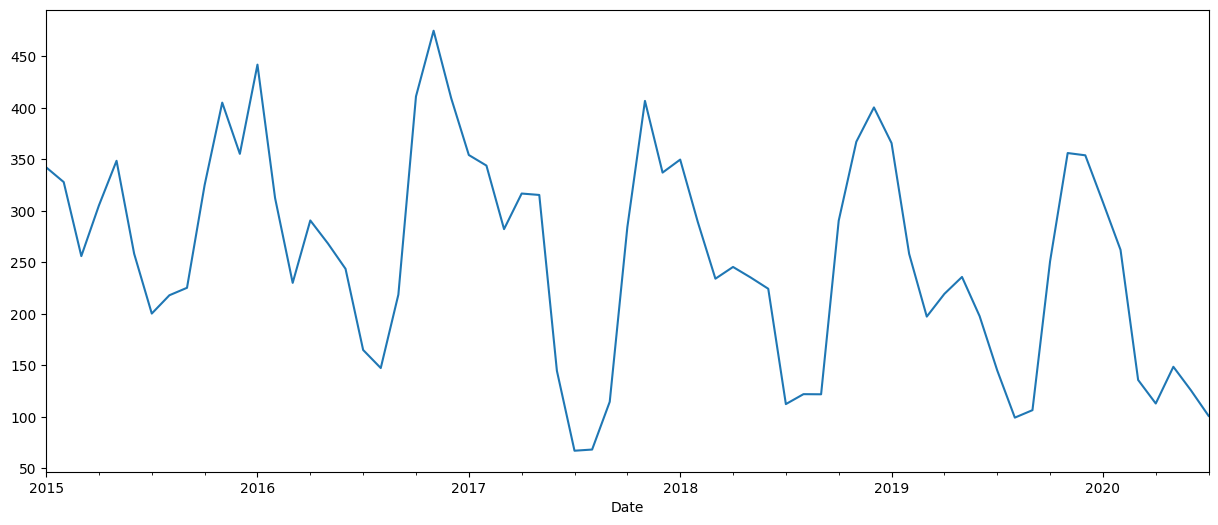

In [14]:
ts_series_month_avg = ts_series["AQI"].resample('MS').mean()
ts_series_month_avg.plot(figsize=(15,6))
plt.show()

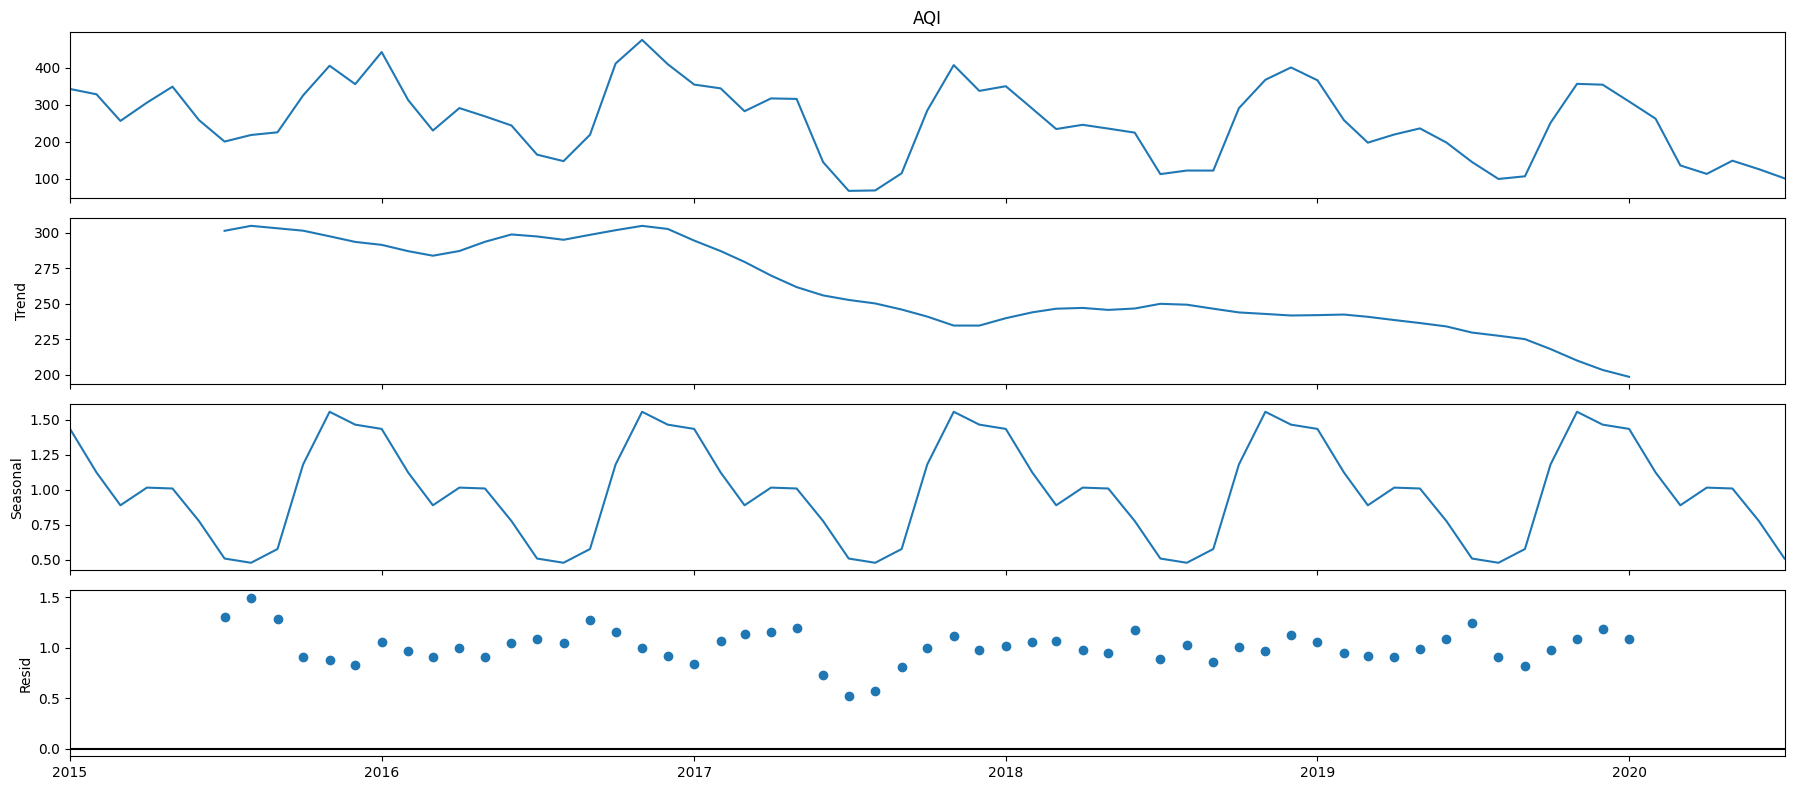

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = seasonal_decompose(ts_series_month_avg, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [16]:
def check_stationarity(timeseries):
    dftest = adfuller(timeseries)
    print('Results of Dickey-Fuller Test:')
    print('Test Statistic: ' + str(dftest[0]))
    print('p-value: ' + str(dftest[1]))

    if dftest[1] > 0.05:
        print("The time series is not stationary")
    else:
        print("The time series is stationary")

In [17]:
def difference(dataset, interval =1):
  diff=list()
  for i in range(interval,len(dataset)):
    value = dataset[i] - (dataset[i - interval])
    diff.append( value)
  return pd.Series(diff)

In [18]:
check_stationarity(ts_series_month_avg)

Results of Dickey-Fuller Test:
Test Statistic: 0.22902373537469978
p-value: 0.9738432644633125
The time series is not stationary


In [21]:
ts_series_month_diff = ts_series_month_avg.diff().dropna()

In [22]:
check_stationarity(ts_series_month_diff)

Results of Dickey-Fuller Test:
Test Statistic: -6.795995344007079
p-value: 2.300251837798964e-09
The time series is stationary


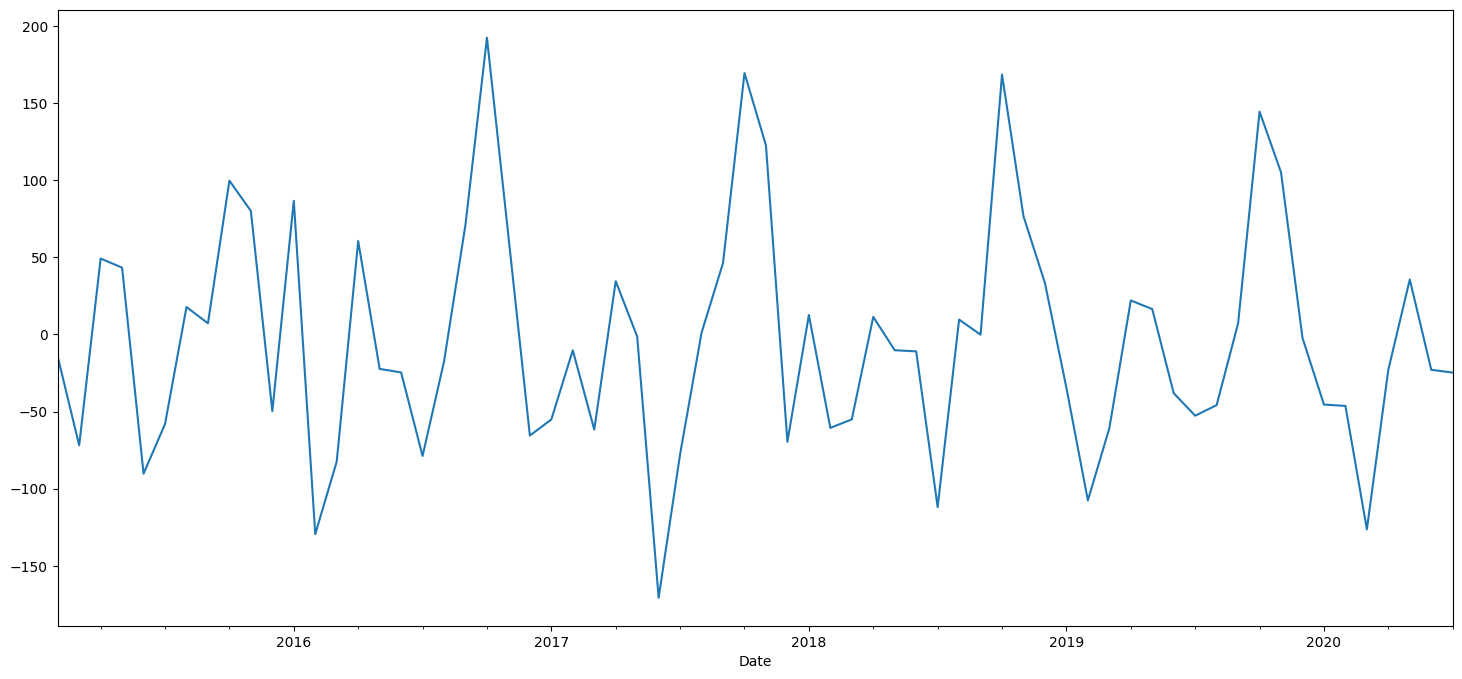

In [23]:
ts_series_month_diff.plot()
plt.show()

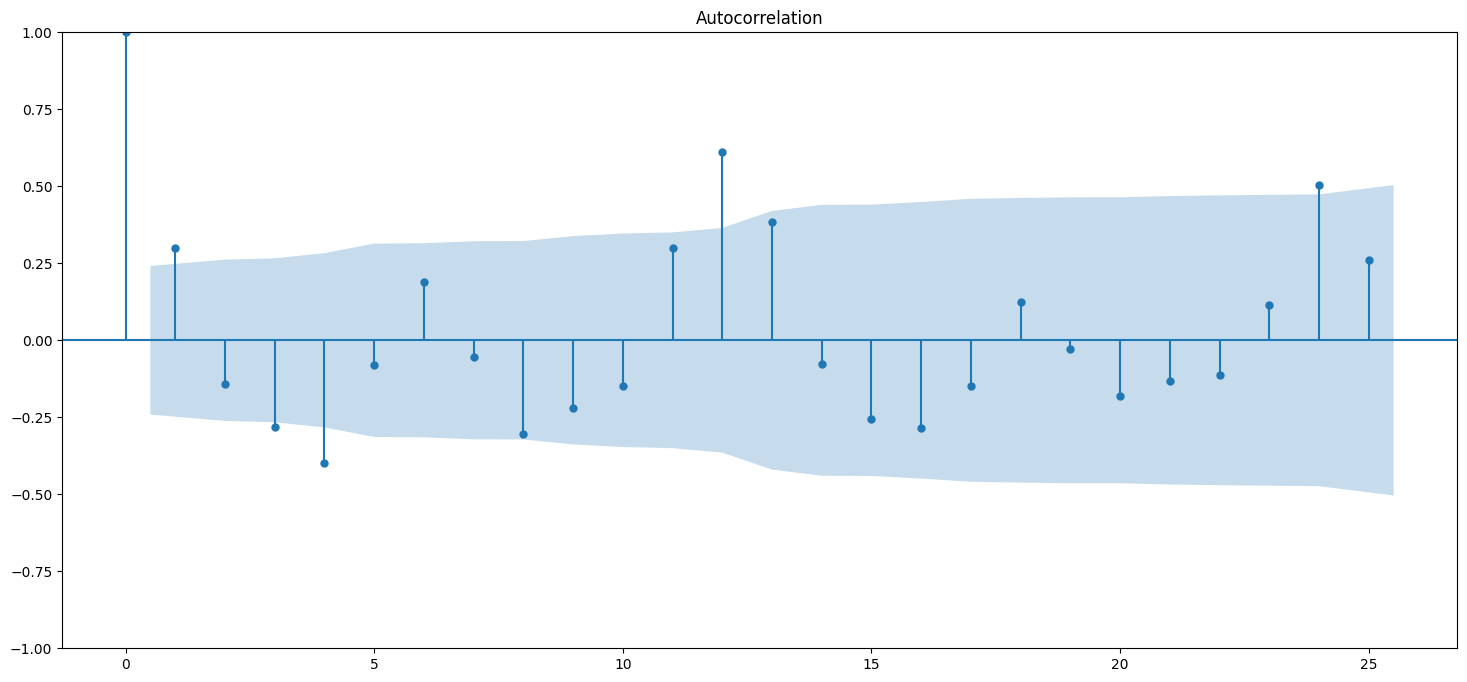

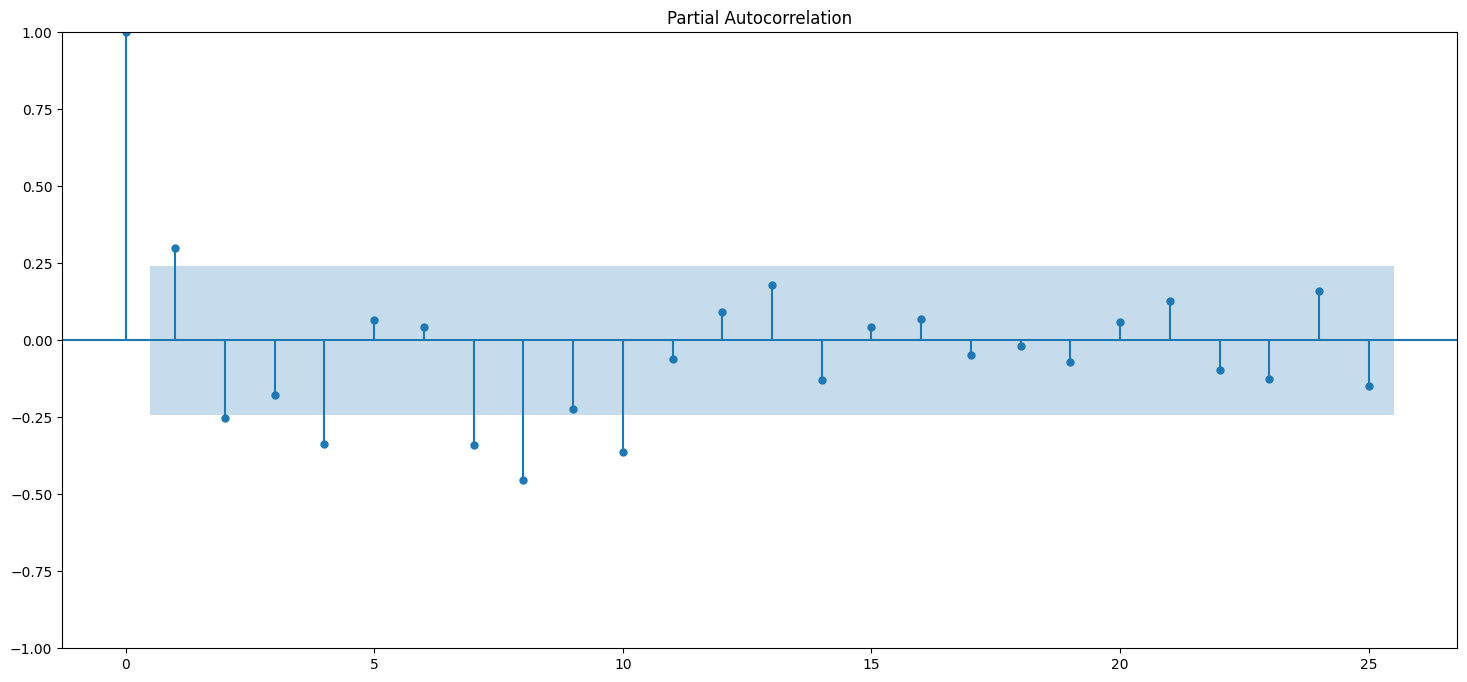

In [27]:
plt.figsize=(12,6)
plot_acf(ts_series_month_diff,lags = 25)
plot_pacf(ts_series_month_diff,lags = 25)
plt.show()

- Step 1: Plot ACF/PACF on the original data to check for stationarity.
- Step 2: If non-stationary, apply differencing (e.g., first or seasonal differencing).
- Step 3: Plot ACF/PACF on the differenced data to identify AR and MA terms.

In [28]:
train = ts_series_month_avg[0:54]
test = ts_series_month_avg[54:]

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima = SARIMAX(train, order=(1,1,1),seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
fitted = sarima.fit()
print(fitted.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                AQI   No. Observations:                   54
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -136.297
Date:                            Sun, 01 Dec 2024   AIC                            282.594
Time:                                    03:16:04   BIC                            289.073
Sample:                                01-01-2015   HQIC                           284.521
                                     - 06-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5577      0.360      1.548      0.122      -0.148       1.264
ma.L1         -1.0000   4047.619   

In [30]:
pred_test = fitted.predict(start=test.index.min(), end=test.index.max())
pred_test

,predicted_mean
2019-07-01,99.046225
2019-08-01,81.056127
2019-09-01,126.952271
2019-10-01,294.350427
2019-11-01,384.345722
2019-12-01,317.861926
2020-01-01,310.773698
2020-02-01,251.670788
2020-03-01,183.941744
2020-04-01,221.555778


### ACF and PACF Patterns for Model Identification

| **Pattern**      | **ACF Behavior**                      | **PACF Behavior**                  | **Suggested Model** |
|------------------|----------------------------------------|------------------------------------|---------------------|
| **AR(p)**        | Gradual decay                          | Cuts off after lag \(p\)           | AR(p)              |
| **MA(q)**        | Cuts off after lag \(q\)               | Gradual decay                      | MA(q)              |
| **ARMA(p, q)**   | Gradual decay in both ACF and PACF     | Gradual decay in both ACF and PACF | ARMA(p, q)         |

### Conclusion:
1. **Use ACF** to identify the **MA(q)** order.
2. **Use PACF** to identify the **AR(p)** order.
3. **Apply differencing (\(d\))** first if the series is non-stationary.


In [54]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
mape = mean_absolute_percentage_error(test, pred_test)
mae = mean_absolute_error(test, pred_test)
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

MAE: 37.451739906139096
MAPE: 0.2628844330158202


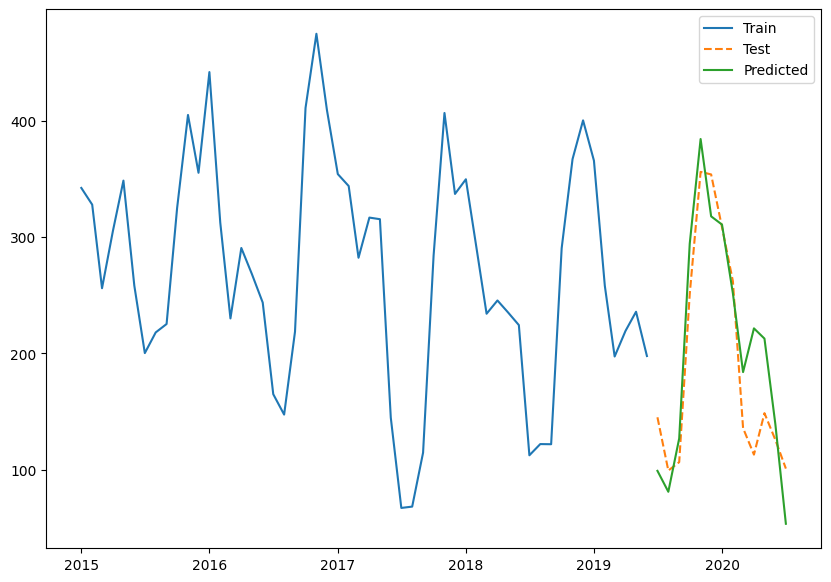

In [34]:
plt.figure(figsize=(10,7))
plt.plot(train, label="Train")
plt.plot(test, label="Test",linestyle = "--")
plt.plot(pred_test, label="Predicted")
plt.legend()
plt.show()

In [35]:
ts_series_month_avg[-1:]

,AQI
Date,
2020-07-01,101.0


In [36]:
forcast_future = fitted.get_prediction(start=pd.to_datetime('2020-08-01'), end=pd.to_datetime('2020-11-01'),dynamic=False)


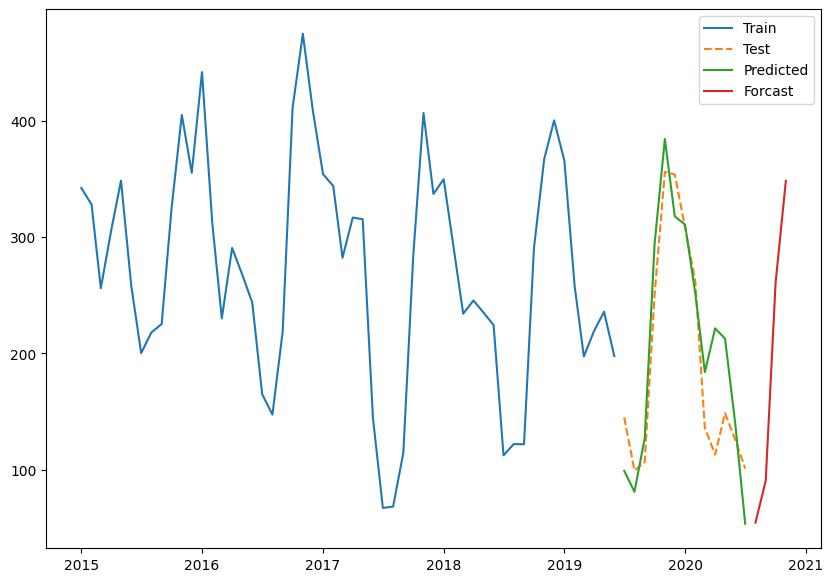

In [37]:
plt.figure(figsize=(10,7))
plt.plot(train, label="Train")
plt.plot(test, label="Test",linestyle = "--")
plt.plot(pred_test, label="Predicted")
plt.plot(forcast_future.predicted_mean, label="Forcast")
plt.legend()
plt.show()

## Auto SARIMA

In [55]:
sarima_model = auto_arima(
    train, start_p=0, start_q =0,
    max_p=12, max_q=12,
    d=None,
    start_P =1,start_Q=1,
    max_P=10, max_Q=10,
    m=12,
    test="adf",
    D=None,
    seasonal = True, #Enables seasonal components in the SARIMA model.
    trace=True,       #Displays score at each step
    error_action ="ignore", #Determines how to handle errors during model fitting
    stepwise= False, # Specifies whether to use a stepwise algorithm for model selection.
    information_criterion="aic"
)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=649.483, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=624.295, Time=0.19 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=inf, Time=4.12 sec
 ARIMA(0,0,0)(0,0,4)[12] intercept   : AIC=inf, Time=3.90 sec
 ARIMA(0,0,0)(0,0,5)[12] intercept   : AIC=inf, Time=4.36 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=606.491, Time=0.28 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=615.360, Time=0.44 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(0,0,0)(1,0,4)[12] intercept   : AIC=inf, Time=6.86 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=606.603, Time=0.59 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=608.722

In [43]:
print(sarima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   54
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -284.587
Date:                            Sun, 01 Dec 2024   AIC                            581.173
Time:                                    03:39:05   BIC                            593.107
Sample:                                01-01-2015   HQIC                           585.776
                                     - 06-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     24.3667     17.089      1.426      0.154      -9.128      57.861
ar.L1          0.8354      0.169   

In [50]:
auto_model = SARIMAX(train, order=(1,0,1),seasonal_order=(2,0,0,12), enforce_stationarity=False, enforce_invertibility=False)
fitted = auto_model.fit()
print(fitted.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 AQI   No. Observations:                   54
Model:             SARIMAX(1, 0, 1)x(2, 0, [], 12)   Log Likelihood                -145.605
Date:                             Sun, 01 Dec 2024   AIC                            301.211
Time:                                     03:40:42   BIC                            308.047
Sample:                                 01-01-2015   HQIC                           303.352
                                      - 06-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4367      0.273      1.602      0.109      -0.097       0.971
ma.L1          0.3198      

In [51]:
pred_auto_model = fitted.predict(start=test.index.min(), end=test.index.max())
pred_auto_model

,predicted_mean
2019-07-01,108.844337
2019-08-01,92.831281
2019-09-01,109.412738
2019-10-01,253.576462
2019-11-01,344.016637
2019-12-01,316.329256
2020-01-01,311.472632
2020-02-01,242.863455
2020-03-01,192.742841
2020-04-01,206.200302


In [52]:
mean_absolute_percentage_error(test, pred_auto_model)

0.2103635806438923

In [53]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(test,pred_auto_model)
print(mae)

30.248554647938256
